In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
! kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 98% 59.0M/60.3M [00:04<00:00, 21.8MB/s]
100% 60.3M/60.3M [00:04<00:00, 13.3MB/s]


In [ ]:
! kaggle datasets download -d apollo2506/facial-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/apollo2506/facial-recognition-dataset
License(s): CC0-1.0
100% 59.7M/59.7M [00:04<00:00, 16.0MB/s]
100% 59.7M/59.7M [00:04<00:00, 12.7MB/s]


In [ ]:
fiel1_name = '/content/facial-recognition-dataset.zip'
file2_name = '/content/fer2013.zip'

In [ ]:
from zipfile import ZipFile

with ZipFile(fiel1_name,'r') as zip:
  zip.extractall()
  print('Done')

with ZipFile(file2_name,'r') as zip:
  zip.extractall()
  print('Done')

Done
Done


In [ ]:
! mkdir data

In [ ]:
import os
import seaborn as sns
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from keras.applications import VGG16, VGG19, ResNet50, ResNet152, MobileNet

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import shutil
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Input

In [ ]:
train_dir = '/content/data/Training'
test_dir = '/content/data/Testing'

def remove_checkpoints(dir_path):
    checkpoints_path = os.path.join(dir_path, '.ipynb_checkpoints')
    if os.path.exists(checkpoints_path):
        shutil.rmtree(checkpoints_path)

remove_checkpoints(train_dir)
remove_checkpoints(test_dir)

data_gen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=10,  # Less rotation
        width_shift_range=0.1,  # Less shift
        height_shift_range=0.1,  # Less shift
        zoom_range=0.1,  # Less zoom
        shear_range=0.1,  # Less shear
        horizontal_flip=True,
        validation_split=0.2,
        fill_mode='nearest',
    )

In [ ]:
def get_generators(target_size):
    train_gen = data_gen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=16,
        class_mode='categorical',
        subset='training',
        color_mode='grayscale'
    )
    val_gen = data_gen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=16,
        class_mode='categorical',
        subset='validation',
        color_mode='grayscale'
    )
    test_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        class_mode='categorical',
        color_mode='grayscale'
    )
    return train_gen, val_gen, test_gen

In [ ]:
def count_images_in_directory(directory):
    class_counts = {}
    # Iterate over class directories and count images
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count the number of files in each class directory
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

In [ ]:
def create_model(base_model, num_classes, input_shape, l2_reg=0.01, dropout_rate=0.5):
    # Create a new input layer with the grayscale input shape
    inputs = Input(shape=input_shape)

    # Add a Conv2D layer to convert grayscale input to 3-channel
    x = Conv2D(3, (3, 3), padding='same')(inputs)

    # Use the base model with this new input layer
    x = base_model(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(x)

    model = Model(inputs=inputs, outputs=predictions)
    return model

In [ ]:
# Define callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

# Define a function to train, evaluate, and plot model metrics
def train_and_evaluate(model, train_gen, val_gen, test_gen, modelName, epochs=15):
    # Display the model summary
    model.summary()

    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    # Plot training and validation accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model.name} - Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot loss and validation loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{modelName} - Training and Validation Loss')
    plt.legend()
    plt.show()

    # Save the model
    model.save(f'{modelName}_model.keras')
    print("Model saved as:", f'{modelName}_model.keras')

    return history

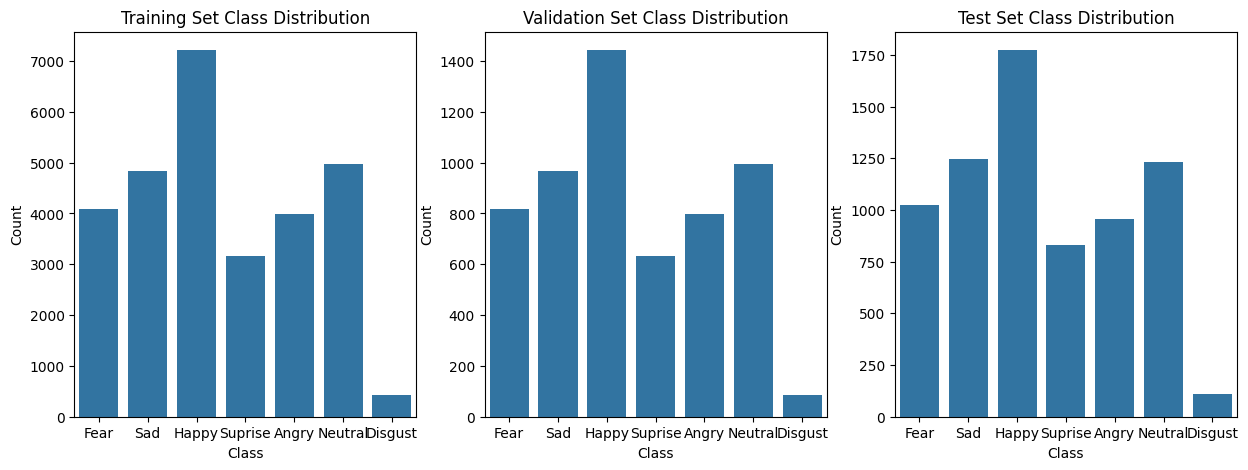

In [ ]:
train_class_counts = count_images_in_directory(train_dir)

# Calculate the validation set class counts based on the split
validation_split = 0.2
val_class_counts = {key: int(value * validation_split) for key, value in train_class_counts.items()}  # Proper multiplication

# Get test set class counts
test_class_counts = count_images_in_directory(test_dir)

# Plot class distribution for training, validation, and test datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), ax=axes[0])
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

sns.barplot(x=list(val_class_counts.keys()), y=list(val_class_counts.values()), ax=axes[1])
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

sns.barplot(x=list(test_class_counts.keys()), y=list(test_class_counts.values()), ax=axes[2])
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')

plt.show()

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
80134624/80134624 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
 

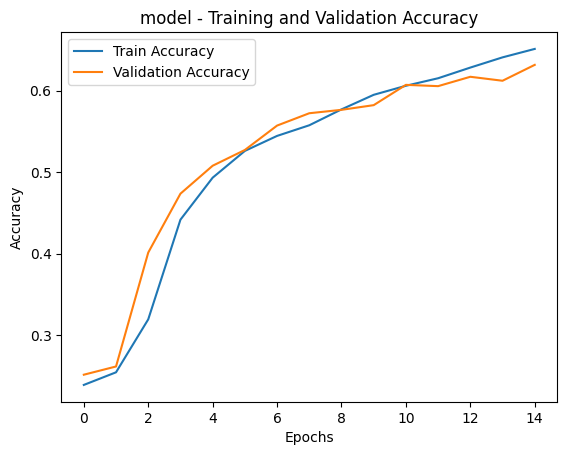

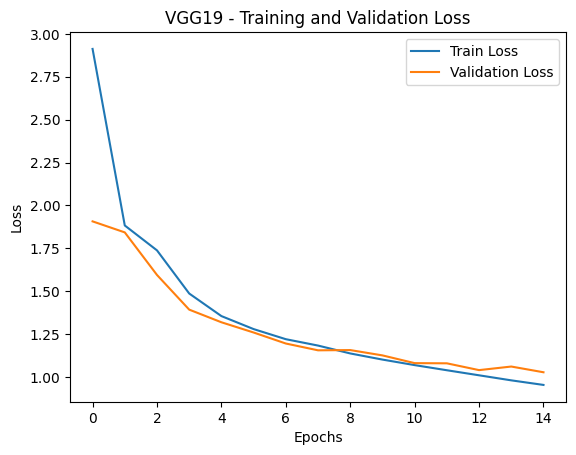

Model saved as: VGG19_model.keras


In [ ]:
from keras.optimizers import Adam
from keras.applications import VGG16, VGG19, ResNet50, ResNet152, MobileNet

train_gen, val_gen, test_gen = get_generators((224, 224))

input_shape = (224, 224, 1)

# VGG19
VGG19_model = create_model(VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), 7, input_shape, l2_reg=0.01, dropout_rate=0.5)
VGG19_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_VGG19 = train_and_evaluate(VGG19_model, train_gen, val_gen, test_gen, "VGG19")

[[6.7717289e-03 1.8240265e-06 2.8513835e-03 1.2103849e-03 9.7590202e-01
  1.3215303e-02 4.7312391e-05]]
[[2.4482103e-03 4.3662589e-05 1.7820231e-03 8.5369396e-01 1.3440143e-01
  6.4368276e-03 1.1938128e-03]]
[[0.10245571 0.00839144 0.09340099 0.04574931 0.15633795 0.57675666
  0.01690796]]
[[0.10245571 0.00839144 0.09340099 0.04574931 0.15633795 0.57675666
  0.01690796]]
[[2.4482103e-03 4.3662589e-05 1.7820231e-03 8.5369396e-01 1.3440143e-01
  6.4368276e-03 1.1938128e-03]]
[[0.10245571 0.00839144 0.09340099 0.04574931 0.15633795 0.57675666
  0.01690796]]
[[1.4636271e-03 6.8224879e-05 9.5048815e-01 7.6157477e-05 1.0959374e-03
  4.5256749e-02 1.5512002e-03]]
[[0.49473056 0.00556618 0.05307392 0.01540189 0.24643563 0.18252867
  0.0022631 ]]
[[0.3044343  0.0043312  0.07476947 0.0038893  0.36619955 0.24220586
  0.00417032]]
[[5.3081737e-04 2.9710966e-06 2.6301859e-04 9.9754286e-01 5.3852750e-04
  1.4289589e-04 9.7894156e-04]]


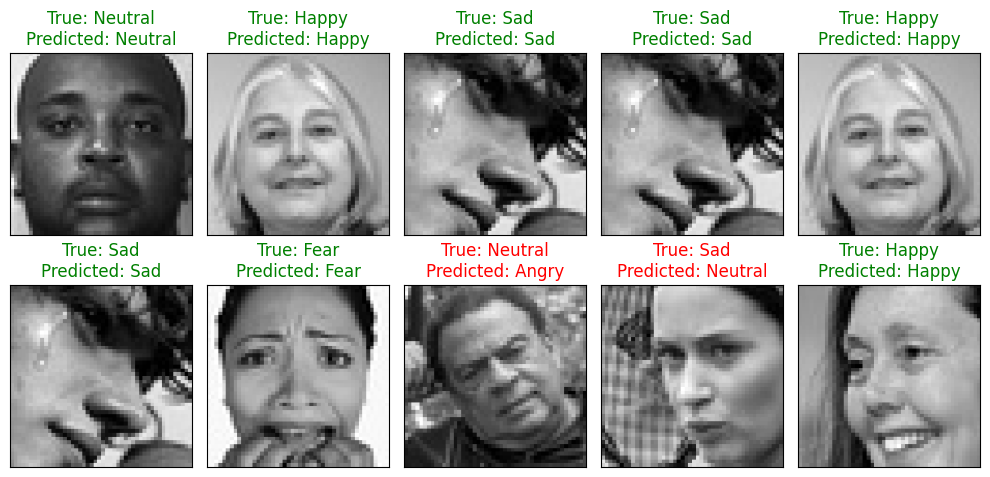

In [ ]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the saved MobileNet model
VGG19_model = load_model("VGG19_model.keras")

# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_gen and model are already defined
batch_size = test_gen.batch_size

# Setting the random seed
np.random.seed()

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_gen) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_gen[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_gen[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(VGG19_model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]
    print(VGG19_model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on the test set and calculate additional metrics
test_loss, test_acc = VGG19_model.evaluate(test_gen)
# Get predictions and ground truth labels from the test set
predictions = VGG19_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)  # Get class with highest probability
true_classes = test_gen.classes

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

# Print precision, recall, and F1 score
print("Accuracy: ", test_acc)
print("Loss: ", test_loss)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

449/449 [==============================] - 35s 77ms/step
Accuracy:  0.6352744698524475
Loss:  1.0183348655700684
Precision: 0.14777817281879754
Recall: 0.14518558605559315
F1 Score: 0.14069999449073273
